In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#Imports:
from comet_ml import Experiment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB,CategoricalNB
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import re
from nltk.corpus import stopwords
import string
from sklearn import preprocessing
from sklearn.manifold import TSNE
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn import svm
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from time import time
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import optuna
sns.set(context='notebook', style='darkgrid', palette='colorblind', font='sans-serif', font_scale=1, rc=None)
matplotlib.rcParams['figure.figsize'] =[8,8]
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['font.family'] = 'sans-serif'

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bartalisd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bartalisd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
from apricot_exp.comet_utils import *
api_key = load_api_key('../../comet_key.txt')

In [4]:
from comet_ml.api import API, APIExperiment
api=API(api_key)

In [5]:
experiments = api.get(workspace = "apricot", project_name = "tweet-disaster")

In [52]:
#FEATURE-BASED - PCA:

In [53]:
def loading_experiments(i):
    exp_param = experiments[i].get_parameters_summary()
    exp_metrics = experiments[i].get_metrics_summary()
    exp_metrics_with_index = pd.DataFrame(experiments[i].get_metrics()).reset_index()
    num_metrics = len(exp_metrics_with_index["metricName"].unique())
    num_experiments = len(exp_metrics_with_index)/num_metrics
    exp_metrics_with_index["exp_index"] = exp_metrics_with_index["index"] % num_experiments
    exp_df = exp_metrics_with_index.pivot(columns="metricName", values="metricValue", index="exp_index").reset_index()
    best_exp_df=exp_df.iloc[np.argmax(exp_df["roc"])]
    function = next(item for item in exp_param if item["name"] == "function")
    function_name = function['valueMax']
    size = next(item for item in exp_param if item["name"] == "size")
    size_value = size['valueMax']
    acc_value = best_exp_df['acc']
    pre_value = best_exp_df['pre']
    rec_value = best_exp_df['rec']
    roc_value = best_exp_df['roc']
    time_value = best_exp_df['running_time']
    return function_name, size_value, acc_value, pre_value, rec_value, roc_value, time_value

In [54]:
df = pd.DataFrame()
for i in range(55,66):
    function_name, size_value, acc_value, pre_value, rec_value, roc_value, time_value = loading_experiments(i)
    dictionary = {'Function': function_name, 'Size': size_value, 'Accuracy': acc_value, 'Precision': pre_value, 'Recall': rec_value, 'AUC': roc_value, 'Running time': time_value }
    df = df.append(dictionary, ignore_index = True)

In [55]:
print(df)

                   AUC            Accuracy      Function           Precision  \
0    0.756843500344408  0.7071333628710678  featurebased  0.7517241379310344   
1   0.8359491177360483  0.7673903411608329  featurebased  0.7915531335149864   
2   0.8491460611951924  0.7833407177669472  featurebased  0.8044619422572179   
3   0.8593785205260751  0.7979618963225521  featurebased  0.8239895697522817   
4    0.860758566747565   0.797075764288879  featurebased  0.8226857887874837   
5   0.8617499468903496  0.7975188303057156  featurebased  0.8237597911227154   
6   0.7614592117884111  0.7226406734603456           PCA  0.8067542213883677   
7   0.8290050309323479  0.7820115197164378           PCA  0.7787182587666264   
8   0.8321895982335408  0.7740363314133806           PCA  0.7537227949599083   
9   0.7852350343442407  0.7337173238812583           PCA  0.6868365180467091   
10  0.7820025878884247  0.7270713336287107           PCA  0.6779303062302007   

                 Recall        Running 

In [56]:
data=df.copy()
data['Size']=data['Size'].apply(lambda x: int(x))
data['percentage']=data['Size'].apply(lambda x: x / 100)
data['percentage'] = data['percentage'].astype("int")
data['AUC'] = data['AUC'].astype("float")
data['Accuracy'] = data['Accuracy'].astype("float")
data['Precision'] = data['Precision'].astype("float")
data['Recall'] = data['Recall'].astype("float")
data['Running time'] = data['Running time'].astype("float")
print(data)

         AUC  Accuracy      Function  Precision    Recall  Running time  Size  \
0   0.756844  0.707133  featurebased   0.751724  0.457503      5.451818   100   
1   0.835949  0.767390  featurebased   0.791553  0.609654     28.194223   500   
2   0.849146  0.783341  featurebased   0.804462  0.643232     80.687606  1000   
3   0.859379  0.797962  featurebased   0.823990  0.663169    266.356792  2500   
4   0.860759  0.797076  featurebased   0.822686  0.662120    685.441712  5000   
5   0.861750  0.797519  featurebased   0.823760  0.662120   1525.776293  7500   
6   0.761459  0.722641           PCA   0.806754  0.451207      7.890397   100   
7   0.829005  0.782012           PCA   0.778718  0.675761     24.840324   500   
8   0.832190  0.774036           PCA   0.753723  0.690451     32.868736  1000   
9   0.785235  0.733717           PCA   0.686837  0.678909    120.760589  2500   
10  0.782003  0.727071           PCA   0.677930  0.673662    267.553999  5000   

    percentage  
0         

In [57]:
data.dtypes

AUC             float64
Accuracy        float64
Function         object
Precision       float64
Recall          float64
Running time    float64
Size              int64
percentage        int64
dtype: object

In [58]:
data_for_pca = data.loc[data["Size"] <= 5000]

In [59]:
data_for_pca.shape

(10, 8)

In [60]:
def lineplot_res(dataframe, y_name, metric, res5k):
    data=dataframe.copy()
    functions=['featurebased', 'PCA']
    result=data[data['Function'].isin(functions)]
    result=data.groupby(by=['Function','percentage'])[metric].mean().reset_index()
    ax=sns.lineplot(data=result, x='percentage', y=metric, hue='Function', palette=['yellow', 'b'])
    plt.xlabel('Number of features', fontsize= 15)
    plt.ylabel(y_name, fontsize= 15)
    plt.axhline(y=res5k, color='brown', linestyle='--')
    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    plt.setp(ax.get_legend().get_title(), fontsize='20')
    return ax

<AxesSubplot:xlabel='Number of features', ylabel='Accuracy'>

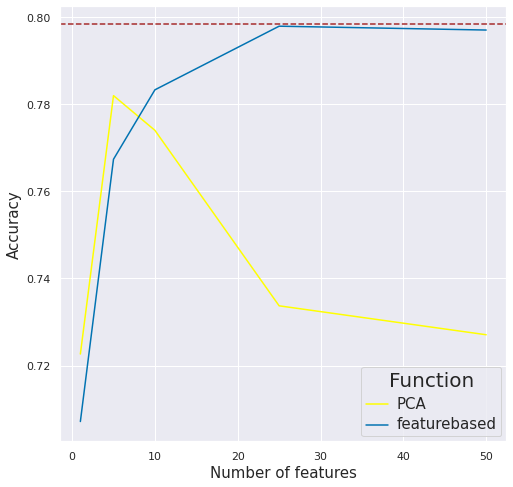

In [62]:
lineplot_res(data_for_pca, 'Accuracy', 'Accuracy', 0.7984049623393886)

<AxesSubplot:xlabel='Number of features', ylabel='Recall'>

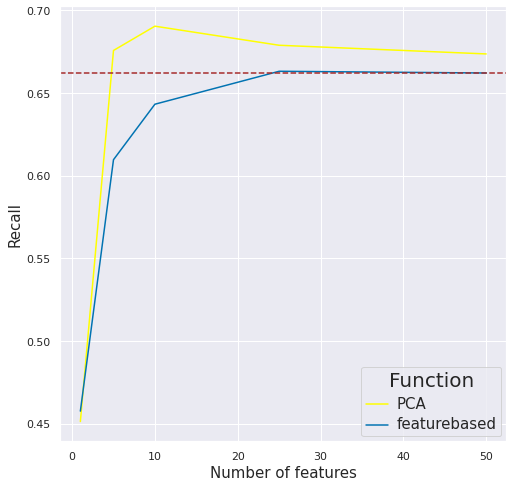

In [63]:
lineplot_res(data_for_pca, 'Recall', 'Recall', 0.6621196222455404 )

<AxesSubplot:xlabel='Number of features', ylabel='Precision'>

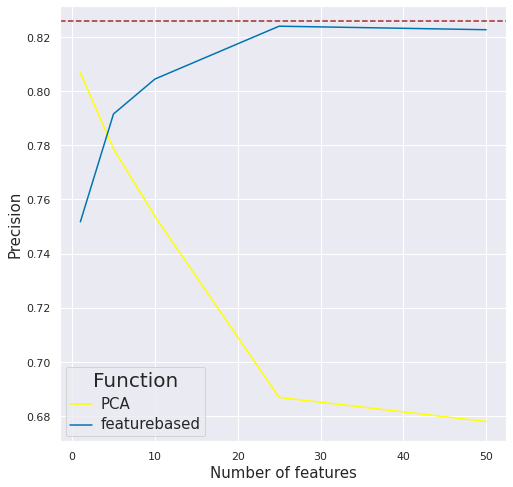

In [64]:
lineplot_res(data_for_pca, 'Precision', 'Precision', 0.8259162303664922)

<AxesSubplot:xlabel='Number of features', ylabel='ROC AUC'>

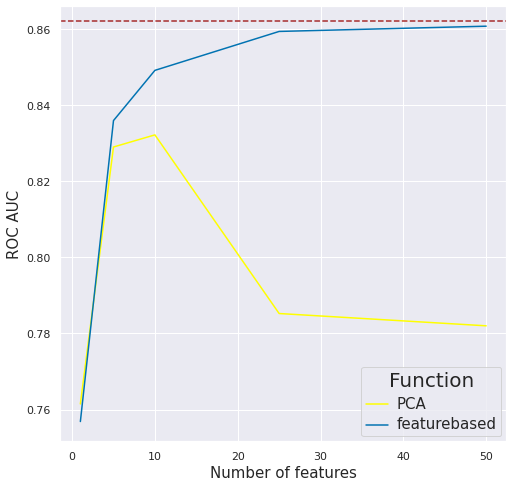

In [65]:
lineplot_res(data_for_pca, 'ROC AUC', 'AUC', 0.8622086211447222)

In [66]:
def lineplot_res_time(dataframe, y_name, metric):
    data=dataframe.copy()
    functions=['featurebased', 'PCA']
    result=data[data['Function'].isin(functions)]
    result=data.groupby(by=['Function','percentage'])[metric].mean().reset_index()
    ax=sns.lineplot(data=result, x='percentage', y=metric, hue='Function', palette=['yellow', 'b'])
    plt.xlabel('Number of features', fontsize= 15)
    plt.ylabel(y_name, fontsize= 15)
    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    plt.setp(ax.get_legend().get_title(), fontsize='20')
    return ax

<AxesSubplot:xlabel='Number of features', ylabel='Running time'>

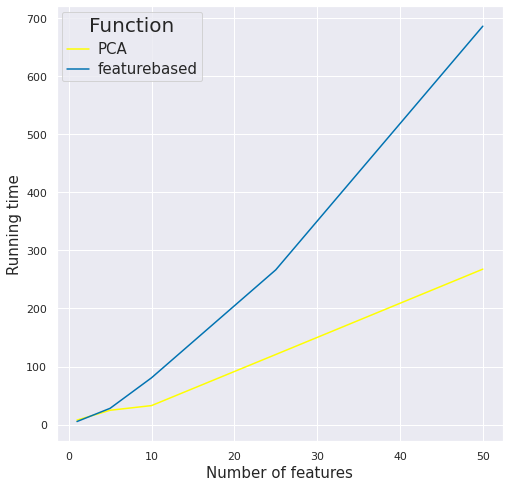

In [67]:
lineplot_res_time(data_for_pca, 'Running time', 'Running time')

In [6]:
#NAIVE - LAZY - TWO-STAGE:

In [7]:
def loading_experiments_opt(i):
    exp_param = experiments[i].get_parameters_summary()
    exp_metrics = experiments[i].get_metrics_summary()
    exp_metrics_with_index = pd.DataFrame(experiments[i].get_metrics()).reset_index()
    num_metrics = len(exp_metrics_with_index["metricName"].unique())
    num_experiments = len(exp_metrics_with_index)/num_metrics
    exp_metrics_with_index["exp_index"] = exp_metrics_with_index["index"] % num_experiments
    exp_df = exp_metrics_with_index.pivot(columns="metricName", values="metricValue", index="exp_index").reset_index()
    best_exp_df=exp_df.iloc[np.argmax(exp_df["roc"])]
    function = next(item for item in exp_param if item["name"] == "function")
    function_name = function['valueMax']
    size = next(item for item in exp_param if item["name"] == "size")
    size_value = size['valueMax']
    optimizer = next(item for item in exp_param if item["name"] == "optimizer")
    optimizer_name = optimizer['valueMax']
    acc_value = best_exp_df['acc']
    pre_value = best_exp_df['pre']
    rec_value = best_exp_df['rec']
    roc_value = best_exp_df['roc']
    time_value = best_exp_df['running_time']
    return function_name, size_value, acc_value, pre_value, rec_value, roc_value, time_value, optimizer_name

In [8]:
df = pd.DataFrame()
for i in range(7,31):
    function_name, size_value, acc_value, pre_value, rec_value, roc_value, time_value, optimizer_name = loading_experiments_opt(i)
    dictionary = {'Function': function_name, 'Size': size_value, 'Accuracy': acc_value, 'Precision': pre_value, 'Recall': rec_value, 'AUC': roc_value, 'Running time': time_value, 'Optimizer': optimizer_name }
    df = df.append(dictionary, ignore_index = True)

In [9]:
print(df)

                   AUC            Accuracy      Function  Optimizer  \
0   0.7493184261518356  0.7013735046521932  featurebased      naive   
1   0.7493184261518356  0.7013735046521932  featurebased       lazy   
2   0.7493184261518356  0.7013735046521932  featurebased  two-stage   
3   0.8359370473609331   0.770048737261852  featurebased      naive   
4   0.8359370473609331   0.770048737261852  featurebased       lazy   
5   0.8359370473609331   0.770048737261852  featurebased  two-stage   
6   0.8487413012830004  0.7828976517501107  featurebased      naive   
7   0.8487413012830004  0.7828976517501107  featurebased       lazy   
8   0.8487413012830004  0.7828976517501107  featurebased  two-stage   
9   0.8593060982753846  0.7957465662383695  featurebased      naive   
10  0.8593060982753846  0.7957465662383695  featurebased       lazy   
11  0.8593060982753846  0.7957465662383695  featurebased  two-stage   
12   0.860358634985419  0.7966326982720425  featurebased      naive   
13   0

In [10]:
data=df.copy()
data['Size']=data['Size'].apply(lambda x: int(x))
data['percentage']=data['Size'].apply(lambda x: x / 100)
data['percentage'] = data['percentage'].astype("int")
data['AUC'] = data['AUC'].astype("float")
data['Accuracy'] = data['Accuracy'].astype("float")
data['Precision'] = data['Precision'].astype("float")
data['Recall'] = data['Recall'].astype("float")
data['Running time'] = data['Running time'].astype("float")
print(data)

         AUC  Accuracy      Function  Optimizer  Precision    Recall  \
0   0.749318  0.701374  featurebased      naive   0.740933  0.450157   
1   0.749318  0.701374  featurebased       lazy   0.740933  0.450157   
2   0.749318  0.701374  featurebased  two-stage   0.740933  0.450157   
3   0.835937  0.770049  featurebased      naive   0.794837  0.613851   
4   0.835937  0.770049  featurebased       lazy   0.794837  0.613851   
5   0.835937  0.770049  featurebased  two-stage   0.794837  0.613851   
6   0.848741  0.782898  featurebased      naive   0.804205  0.642183   
7   0.848741  0.782898  featurebased       lazy   0.804205  0.642183   
8   0.848741  0.782898  featurebased  two-stage   0.804205  0.642183   
9   0.859306  0.795747  featurebased      naive   0.820312  0.661070   
10  0.859306  0.795747  featurebased       lazy   0.820312  0.661070   
11  0.859306  0.795747  featurebased  two-stage   0.820312  0.661070   
12  0.860359  0.796633  featurebased      naive   0.822454  0.66

In [45]:
def lineplot_res_opt(dataframe, y_name, metric, mod):
    data=dataframe.copy()
    optimizers=['naive', 'lazy', 'two-stage']
    result=data[data['Optimizer'].isin(optimizers)]
    #result=data.groupby(by=['Optimizer','percentage'])[metric].mean().reset_index()
    ax=sns.lineplot(data=result, x='percentage', y=metric, hue='Optimizer', palette=['purple', 'red', 'black'])
    ax.set_title(mod,fontdict= { 'fontsize': 20, 'fontweight':'bold'})
    plt.xlabel('Number of features', fontsize= 15)
    plt.ylabel(y_name, fontsize= 15)
    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    plt.setp(ax.get_legend().get_title(), fontsize='20')
    return ax

<AxesSubplot:title={'center':'NLP - Disasters tweets: Dim reduction'}, xlabel='Number of features', ylabel='Running time'>

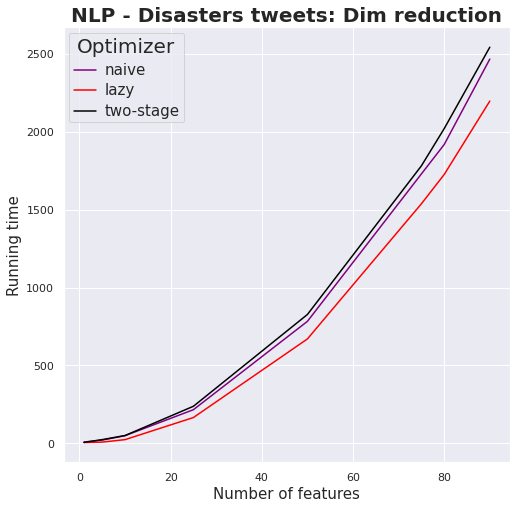

In [46]:
lineplot_res_opt(data, 'Running time', 'Running time', 'NLP - Disasters tweets: Dim reduction' )

In [6]:
# NON DETERMINISTIC OPTIMIZERS:

In [6]:
def loading_experiments_opt(i):
    exp_param = experiments[i].get_parameters_summary()
    exp_metrics = experiments[i].get_metrics_summary()
    exp_metrics_with_index = pd.DataFrame(experiments[i].get_metrics()).reset_index()
    num_metrics = len(exp_metrics_with_index["metricName"].unique())
    num_experiments = len(exp_metrics_with_index)/num_metrics
    exp_metrics_with_index["exp_index"] = exp_metrics_with_index["index"] % num_experiments
    exp_df = exp_metrics_with_index.pivot(columns="metricName", values="metricValue", index="exp_index").reset_index()
    best_exp_df=exp_df.iloc[np.argmax(exp_df["roc"])]
    function = next(item for item in exp_param if item["name"] == "function")
    function_name = function['valueMax']
    size = next(item for item in exp_param if item["name"] == "size")
    size_value = size['valueMax']
    optimizer = next(item for item in exp_param if item["name"] == "optimizer")
    optimizer_name = optimizer['valueMax']
    acc_value = best_exp_df['acc']
    pre_value = best_exp_df['pre']
    rec_value = best_exp_df['rec']
    roc_value = best_exp_df['roc']
    time_value = best_exp_df['running_time']
    return function_name, size_value, acc_value, pre_value, rec_value, roc_value, time_value, optimizer_name

In [7]:
df = pd.DataFrame()
for i in range(66,307):
    function_name, size_value, acc_value, pre_value, rec_value, roc_value, time_value, optimizer_name = loading_experiments_opt(i)
    dictionary = {'Function': function_name, 'Size': size_value, 'Accuracy': acc_value, 'Precision': pre_value, 'Recall': rec_value, 'AUC': roc_value, 'Running time': time_value, 'Optimizer': optimizer_name }
    df = df.append(dictionary, ignore_index = True)

In [8]:
for i in range(7,31):
    function_name, size_value, acc_value, pre_value, rec_value, roc_value, time_value, optimizer_name = loading_experiments_opt(i)
    dictionary = {'Function': function_name, 'Size': size_value, 'Accuracy': acc_value, 'Precision': pre_value, 'Recall': rec_value, 'AUC': roc_value, 'Running time': time_value, 'Optimizer': optimizer_name }
    df = df.append(dictionary, ignore_index = True)

In [13]:
df.head()

,AUC,Accuracy,Function,Optimizer,Precision,Recall,Running time,Size
0,0.7481033417235852,0.7031457687195393,featurebased,approximate-lazy,0.7427101200686106,0.45435466946484787,9.62055253982544,100
1,0.7481033417235852,0.7031457687195393,featurebased,approximate-lazy,0.7427101200686106,0.45435466946484787,9.731337308883667,100
2,0.7481033417235852,0.7031457687195393,featurebased,approximate-lazy,0.7427101200686106,0.45435466946484787,10.655607461929321,100
3,0.7481033417235852,0.7031457687195393,featurebased,approximate-lazy,0.7427101200686106,0.45435466946484787,10.460378408432007,100
4,0.7481033417235852,0.7031457687195393,featurebased,approximate-lazy,0.7427101200686106,0.45435466946484787,9.455285787582397,100


In [9]:
data=df.copy()
data['Size']=data['Size'].apply(lambda x: int(x))
data['percentage']=data['Size'].apply(lambda x: x / 100)
data['percentage'] = data['percentage'].astype("int")
data['AUC'] = data['AUC'].astype("float")
data['Accuracy'] = data['Accuracy'].astype("float")
data['Precision'] = data['Precision'].astype("float")
data['Recall'] = data['Recall'].astype("float")
data['Running time'] = data['Running time'].astype("float")
print(data)

          AUC  Accuracy      Function         Optimizer  Precision    Recall  \
0    0.748103  0.703146  featurebased  approximate-lazy   0.742710  0.454355   
1    0.748103  0.703146  featurebased  approximate-lazy   0.742710  0.454355   
2    0.748103  0.703146  featurebased  approximate-lazy   0.742710  0.454355   
3    0.748103  0.703146  featurebased  approximate-lazy   0.742710  0.454355   
4    0.748103  0.703146  featurebased  approximate-lazy   0.742710  0.454355   
..        ...       ...           ...               ...        ...       ...   
260  0.861663  0.796190  featurebased              lazy   0.821382  0.661070   
261  0.861663  0.796190  featurebased         two-stage   0.821382  0.661070   
262  0.862175  0.797962  featurebased             naive   0.825688  0.661070   
263  0.862175  0.797962  featurebased              lazy   0.825688  0.661070   
264  0.862175  0.797962  featurebased         two-stage   0.825688  0.661070   

     Running time  Size  percentage  
0

In [53]:
def lineplot_res_opt(dataframe, y_name, metric, res5k):
    data=dataframe.copy()
    optimizers=[ 'lazy', 'approximate-lazy', 'stochastic', 'sample']
    data=data[data['Optimizer'].isin(optimizers)]
    result=data.groupby(by=['Optimizer','percentage'])[metric].mean().reset_index()
    ax=sns.lineplot(data=result, x='percentage', y=metric, hue='Optimizer', palette=['green', 'blue', 'red', 'black'])
    plt.axhline(y=res5k, color='brown', linestyle='--')
    plt.xlabel('Number of features', fontsize= 15)
    plt.ylabel(y_name, fontsize= 15)
    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    plt.setp(ax.get_legend().get_title(), fontsize='20')
    return ax

<AxesSubplot:xlabel='Number of features', ylabel='Accuracy'>

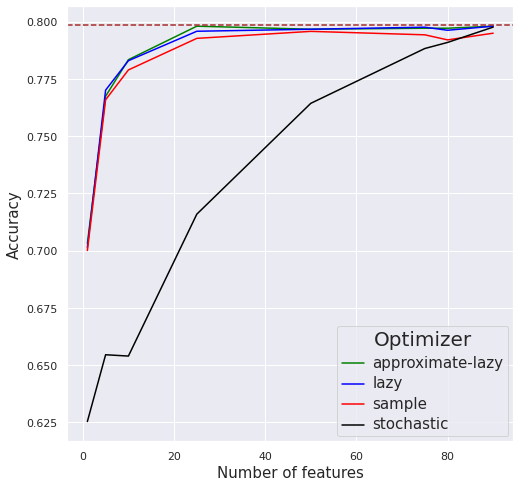

In [54]:
lineplot_res_opt(data, 'Accuracy', 'Accuracy', 0.7984049623393886 )

<AxesSubplot:xlabel='Number of features', ylabel='Recall'>

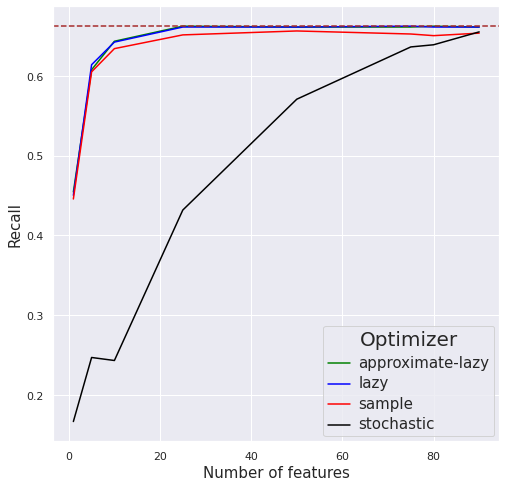

In [55]:
lineplot_res_opt(data, 'Recall', 'Recall', 0.6621196222455404)

<AxesSubplot:xlabel='Number of features', ylabel='Precision'>

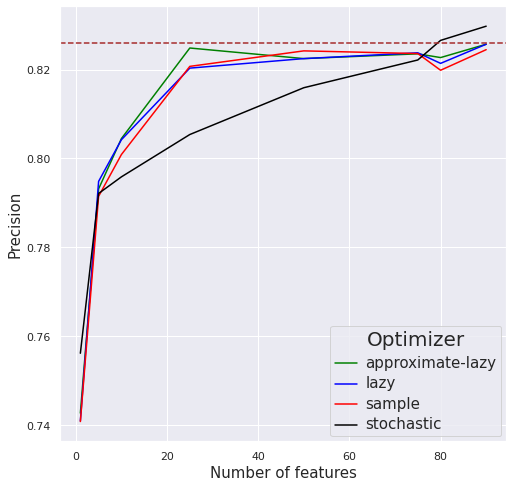

In [56]:
lineplot_res_opt(data, 'Precision', 'Precision', 0.8259162303664922 )

<AxesSubplot:xlabel='Number of features', ylabel='ROC AUC'>

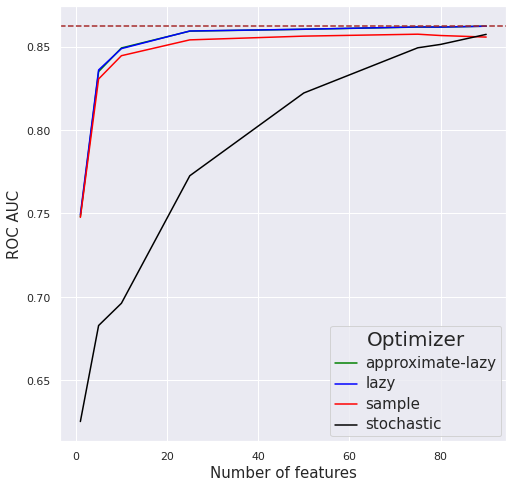

In [57]:
lineplot_res_opt(data, 'ROC AUC', 'AUC', 0.8622086211447222 )

In [20]:
def lineplot_res_opt_time(dataframe, y_name, metric):
    data=dataframe.copy()
    optimizers=['naive', 'lazy', 'two-stage', 'approximate-lazy', 'stochastic', 'sample']
    data=data[data['Optimizer'].isin(optimizers)]
    result=data.groupby(by=['Optimizer','percentage'])[metric].mean().reset_index()
    ax=sns.lineplot(data=result, x='percentage', y=metric, hue='Optimizer', palette=['purple', 'blue', 'green', 'red', 'black', 'orange'])
    plt.xlabel('Number of features', fontsize= 15)
    plt.ylabel(y_name, fontsize= 15)
    plt.setp(ax.get_legend().get_texts(), fontsize='15')
    plt.setp(ax.get_legend().get_title(), fontsize='20')
    return ax

<AxesSubplot:xlabel='Number of features', ylabel='Running time'>

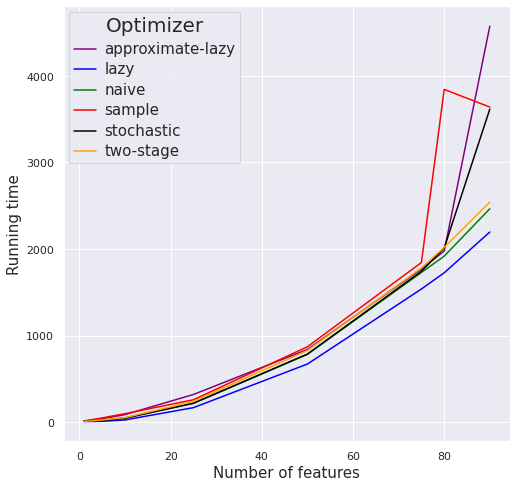

In [21]:
lineplot_res_opt_time(data, 'Running time', 'Running time')

In [32]:
data=df.copy()
data['Size']=data['Size'].apply(lambda x: int(x))
data['percentage']=data['Size'].apply(lambda x: x / 100)
data['percentage'] = data['percentage'].astype("int")
data['AUC'] = data['AUC'].astype("float")
data['Accuracy'] = data['Accuracy'].astype("float")
data['Precision'] = data['Precision'].astype("float")
data['Recall'] = data['Recall'].astype("float")
data['Running time'] = data['Running time'].astype("float")
optimizers=['naive', 'lazy', 'two-stage', 'approximate-lazy', 'stochastic', 'sample']
data=data[data['Optimizer'].isin(optimizers)]
result=data.groupby(by=['Optimizer','percentage'])['Running time'].mean().reset_index()

In [43]:
result.reset_index(drop=True)

,Optimizer,percentage,Running time
0,approximate-lazy,1,9.873236
1,approximate-lazy,5,38.291945
2,approximate-lazy,10,85.969635
3,approximate-lazy,25,318.345238
4,approximate-lazy,50,838.844244
5,approximate-lazy,75,1768.717049
6,approximate-lazy,80,1975.711872
7,approximate-lazy,90,4575.161211
8,lazy,1,5.853069
9,lazy,5,8.654508


In [48]:
result_df = result.pivot(columns="percentage", values="Running time", index="Optimizer").reset_index()

In [49]:
print(result_df)

percentage         Optimizer          1          5         10          25  \
0           approximate-lazy   9.873236  38.291945  85.969635  318.345238   
1                       lazy   5.853069   8.654508  24.381578  166.213508   
2                      naive   8.792004  21.410439  49.757485  216.478797   
3                     sample  12.153737  47.937251  96.673322  257.529600   
4                 stochastic   8.068281  18.829117  43.255833  217.423227   
5                  two-stage   6.708475  24.621347  50.719619  238.428642   

percentage          50           75           80           90  
0           838.844244  1768.717049  1975.711872  4575.161211  
1           670.319807  1537.300710  1725.072800  2195.865896  
2           783.075958  1728.787673  1917.370126  2465.129879  
3           870.330610  1843.620297  3844.286441  3640.648294  
4           785.123969  1743.091065  2011.981810  3616.855775  
5           827.117485  1780.663245  2019.385015  2541.534533  


In [50]:
result_df.head()

percentage,Optimizer,1,5,10,25,50,75,80,90
0,approximate-lazy,9.873236,38.291945,85.969635,318.345238,838.844244,1768.717049,1975.711872,4575.161211
1,lazy,5.853069,8.654508,24.381578,166.213508,670.319807,1537.300710,1725.072800,2195.865896
2,naive,8.792004,21.410439,49.757485,216.478797,783.075958,1728.787673,1917.370126,2465.129879
3,sample,12.153737,47.937251,96.673322,257.529600,870.330610,1843.620297,3844.286441,3640.648294
4,stochastic,8.068281,18.829117,43.255833,217.423227,785.123969,1743.091065,2011.981810,3616.855775


In [52]:
print(result_df.to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
        Optimizer &          1 &          5 &         10 &          25 &          50 &           75 &           80 &           90 \\
\midrule
 approximate-lazy &   9.873236 &  38.291945 &  85.969635 &  318.345238 &  838.844244 &  1768.717049 &  1975.711872 &  4575.161211 \\
             lazy &   5.853069 &   8.654508 &  24.381578 &  166.213508 &  670.319807 &  1537.300710 &  1725.072800 &  2195.865896 \\
            naive &   8.792004 &  21.410439 &  49.757485 &  216.478797 &  783.075958 &  1728.787673 &  1917.370126 &  2465.129879 \\
           sample &  12.153737 &  47.937251 &  96.673322 &  257.529600 &  870.330610 &  1843.620297 &  3844.286441 &  3640.648294 \\
       stochastic &   8.068281 &  18.829117 &  43.255833 &  217.423227 &  785.123969 &  1743.091065 &  2011.981810 &  3616.855775 \\
        two-stage &   6.708475 &  24.621347 &  50.719619 &  238.428642 &  827.117485 &  1780.663245 &  2019.385015 &  2541.534533 \\
\bottomrule
\end{tabular